In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
#import seaborn as sns
from scipy import signal
import xesmf as xe

#import cartopy.feature as cfeature
#import cartopy.crs as ccrs
#import cartopy.mpl.ticker as cticker
#from cartopy.util import add_cyclic_point
 
from mlprecip_utils import *
from mlprecip_models import *
from mlprecip_datasets import *
from mlprecip_xai import *
from mlprecip_plot import *

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/kpegion

In [2]:
warnings.filterwarnings("ignore")

### Set Variables for plotting, region, etc.

In [3]:
varname='precip'
model_types=['cnn_cat'] #,'logmodel_med']
#model_types=['logmodel_med']

# Define SEUS Region
lat_reg=[24.0,36.0]
lon_reg=[269.0,283.0]

# Define Winter and Summer Months
winter=[12,1,2]
summer=[6,7,8]

In [4]:
files='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.precip.*.nc'
ds=xr.open_mfdataset(files,combine='by_coords')

ds_anoms=ds['precip'].groupby('time.dayofyear')-daily_climo(ds['precip'],'precip')
#ds_anoms=ds.groupby('time.dayofyear')-ds.groupby('time.dayofyear').mean()
ds_anoms

<xarray.Dataset>
Dimensions:    (lat: 73, lon: 144, time: 14246)
Coordinates:
  * lat        (lat) float32 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 1
  * time       (time) datetime64[ns] 1979-01-01T12:00:00 ... 2018-01-01
Data variables:
    precip     (time, lat, lon) float64 dask.array<chunksize=(1, 73, 144), meta=np.ndarray>

## Read in Predictor Fields

#### Filenames

In [5]:
zfiles='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.geoheight.*.nc'
ufiles='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.u.*.nc'
tfiles='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.sea.surface.temperature.0.75.x.0.75.1979-2018.nc'
olrfiles1='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.top.net.thermal.radiation.19*s.nc'
olrfiles2='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.top.net.thermal.radiation.20*s.nc'

#### Z500 and Z850

In [6]:
ds_z=xr.open_mfdataset(zfiles,combine='by_coords')
ds_z500=ds_z.sel(level=500).rename({'z':'z500'})
ds_z850=ds_z.sel(level=850).rename({'z':'z850'})

#### U200 and U850

In [7]:
ds_u=xr.open_mfdataset(ufiles,combine='by_coords')
ds_u200=ds_u.sel(level=200).rename({'u':'u200'})
ds_u850=ds_u.sel(level=850).rename({'u':'u850'})
ds_u250=ds_u.sel(level=250).rename({'u':'u250'})

#### SST

In [8]:
ds_sst=xr.open_mfdataset(tfiles,combine='by_coords')

#### OLR

In [9]:
ds_olr1=xr.open_mfdataset(olrfiles1,combine='by_coords',combine_attrs='drop_conflicts')
ds_olr1['time']=ds_olr1['time'].dt.floor('d')
ds_olr2=xr.open_mfdataset(olrfiles2,combine='by_coords')
ds_olr=xr.combine_by_coords([ds_olr1,ds_olr2],combine_attrs='drop_conflicts').rename({'ttr':'olr'})

### Coarse Grain the Predictor Data

In [10]:
new_lon=np.arange(0,360,5)
new_lat=np.arange(-90,92,5)

ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                      'lon': (['lon'], new_lon)})

regridder = xe.Regridder(ds_anoms,ds_out,'bilinear',periodic=True)
ds_anoms=regridder(ds_anoms)

regridder = xe.Regridder(ds_z500,ds_out,'bilinear',periodic=True)
ds_z500=regridder(ds_z500)
ds_z850=regridder(ds_z850)
ds_u200=regridder(ds_u200)
ds_u250=regridder(ds_u250)
ds_u850=regridder(ds_u850)
ds_olr=regridder(ds_olr)

regridder_sst = xe.Regridder(ds_sst,ds_out,'bilinear',periodic=True)
ds_sst=regridder_sst(ds_sst).fillna(0.0)

### Put all predictors together and make anomalies

In [11]:
ds_features=xr.merge([ds_z500,ds_z850,ds_u200,ds_u850,ds_olr,ds_sst],compat='override')
for v in list(ds_features.keys())
    climo=daily_climo(ds_features[v],v)[v]
    ds_features[v]=ds_features[v].groupby('time.dayofyear')-climo

<xarray.Dataset>
Dimensions:    (time: 58440, lat: 37, lon: 72)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 ... 2018-12-31T18:00:00
    level      float32 500.0
  * lon        (lon) int64 0 5 10 15 20 25 30 35 ... 325 330 335 340 345 350 355
  * lat        (lat) int64 -90 -85 -80 -75 -70 -65 -60 ... 60 65 70 75 80 85 90
    dayofyear  (time) int64 1 1 1 1 2 2 2 2 ... 364 364 364 364 365 365 365 365
Data variables:
    z500       (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>
    z850       (time, lat, lon) float32 dask.array<chunksize=(1460, 37, 72), meta=np.ndarray>
    u200       (time, lat, lon) float32 dask.array<chunksize=(1460, 37, 72), meta=np.ndarray>
    u850       (time, lat, lon) float32 dask.array<chunksize=(1460, 37, 72), meta=np.ndarray>
    olr        (time, lat, lon) float32 dask.array<chunksize=(1460, 37, 72), meta=np.ndarray>
    sst        (time, lat, lon) float32 dask.array<chunksize=(58440, 37, 72), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

### Mask out the SEUS region with zeros in Predictor Data

In [12]:
ds_mask_1=xr.where(np.logical_and(ds_features['lon']>lon_reg[0],ds_features['lon']<lon_reg[1]),1,0)
ds_mask_2=xr.where(np.logical_and(ds_features['lat']>lat_reg[0],ds_features['lat']<lat_reg[1]),1,0)
ds_features=xr.where(ds_mask_1+ds_mask_2==2,0,ds_features)
ds_features=(ds_features.transpose('time','lat','lon'))
ds_features

<xarray.Dataset>
Dimensions:    (lon: 72, lat: 37, time: 58440)
Coordinates:
    level      float32 500.0
  * lon        (lon) int64 0 5 10 15 20 25 30 35 ... 325 330 335 340 345 350 355
  * lat        (lat) int64 -90 -85 -80 -75 -70 -65 -60 ... 60 65 70 75 80 85 90
  * time       (time) datetime64[ns] 1979-01-01 ... 2018-12-31T18:00:00
    dayofyear  (time) int64 1 1 1 1 2 2 2 2 ... 364 364 364 364 365 365 365 365
Data variables:
    z500       (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>
    z850       (time, lat, lon) float32 dask.array<chunksize=(1460, 37, 72), meta=np.ndarray>
    u200       (time, lat, lon) float32 dask.array<chunksize=(1460, 37, 72), meta=np.ndarray>
    u850       (time, lat, lon) float32 dask.array<chunksize=(1460, 37, 72), meta=np.ndarray>
    olr        (time, lat, lon) float32 dask.array<chunksize=(1460, 37, 72), meta=np.ndarray>
    sst        (time, lat, lon) float32 dask.array<chunksize=(58440, 37, 72), meta=np.ndarray>

### Maskout OLR poleward of 30 in predictor Data

In [13]:
ds_features['olr']=xr.where(np.abs(ds_features['lat'])>30,0,ds_features['olr'])

### Split Target and Predictor Data into Test and Train/Validate

In [14]:
# Features
ds_features_tval=ds_features.sel(time=slice('1979-01-01','2016-12-31'))
ds_features_test=ds_features.sel(time=slice('2017-01-01','2019-12-31'))

# Target
weights=np.cos(np.deg2rad(ds_i['lat']))
ds_anoms_tval=ds_anoms.sel(time=slice('1979-01-01','2016-12-31'))
ds_target_tval=(ds_anoms_tval*weights).sel(lat=slice(lat_reg[0],lat_reg[1]),
                       lon=slice(lon_reg[0],lon_reg[1])).mean(dim=['lat','lon'],skipna=True)
ds_anoms_test=ds_anoms.sel(time=slice('2017-01-01','2019-12-31'))
ds_target_test=(ds_anoms_test*weights).sel(lat=slice(lat_reg[0],lat_reg[1]),
                       lon=slice(lon_reg[0],lon_reg[1])).mean(dim=['lat','lon'],skipna=True)


### Write out train and test data

In [ ]:
ds_features_tval.to_netcdf('../data/cnn/features_trainval.nc')
ds_features_test.to_netcdf('../data/cnn/features_test.nc')
ds_target_tval.to_netcdf('../data/cnn/target_trainval.nc')
ds_target_test.to_netcdf('../data/cnn/target_test.nc')

### Main Program to Train and Test Models

Summer
cnn_cat
Upper Cat:  1748
Lower Cat:  1748
Check Features and Target Dimensions
Features (X):  (3496, 37, 72, 6)
Target (Y):  (3496, 2)
Samples:  3496
Features:  37
Training Size:  2796
Validation Size:  700
Epoch 00034: early stopping
Training set accuracy score: 0.7217453532826917
Validation set accuracy score: 0.6571428581540074
Validation ROC AUC score: 0.6886416666666666
Epoch 00031: early stopping
Training set accuracy score: 0.7235336199999708
Validation set accuracy score: 0.6300000000212874
Validation ROC AUC score: 0.647775
Epoch 00030: early stopping
Training set accuracy score: 0.6959942800974812
Validation set accuracy score: 0.6185714325734547
Validation ROC AUC score: 0.6907291666666667
Epoch 00032: early stopping
Training set accuracy score: 0.7181688143587931
Validation set accuracy score: 0.6371428623263325
Validation ROC AUC score: 0.6799083333333333
Epoch 00031: early stopping
Training set accuracy score: 0.7339055785784053
Validation set accuracy score: 0.632

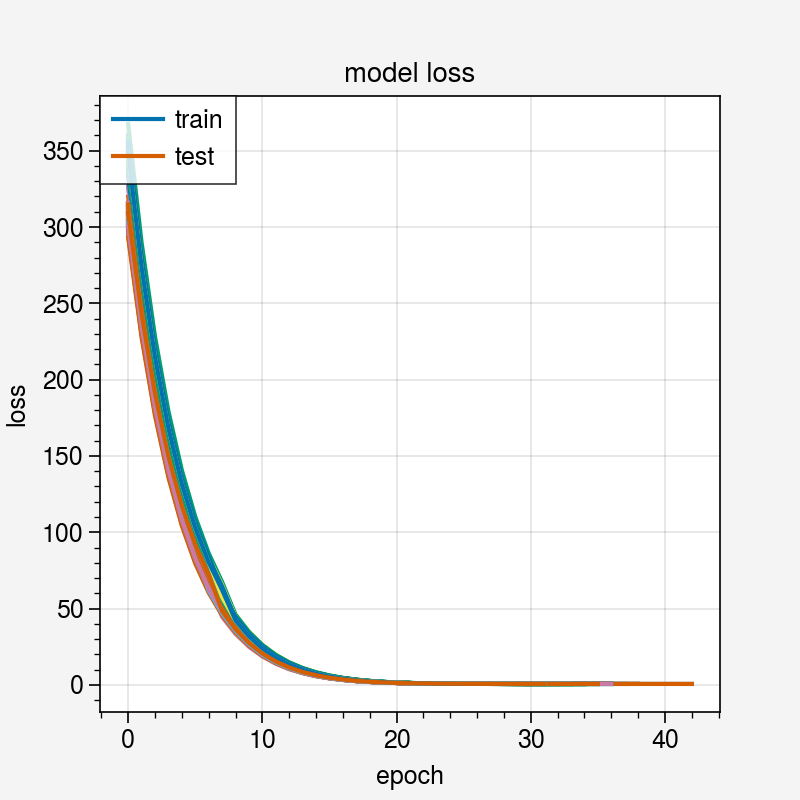

In [15]:
# Loop over seasons
#for seas,slabel,seas_abbrv in zip([winter,summer],['Winter','Summer'],['DJF','JJA']):
for seas,slabel,seas_abbrv in zip([summer],['Summer'],['JJA']):
    
    print(slabel)
                    
    # Select season from target precip anomalies
    ds_i=ds_target_tval.sel(time=ds_anoms_tval['time.month'].isin(seas)) 
    
    # Define Target as Mean precip in region x cos latitude
    #weights=np.cos(np.deg2rad(ds_i['lat']))
    #ds_target=(ds_i*weights).sel(lat=slice(lat_reg[0],lat_reg[1]),
    #                   lon=slice(lon_reg[0],lon_reg[1])).mean(dim=['lat','lon'],skipna=True)

  
    # Make sure we have the same times for target and features
    ds_t,ds_f=xr.align(ds_target_tval.dropna(dim='time'),
                                   ds_features_tval.dropna(dim='time'),
                                   join='inner')

    # Subtract the median to ensure data is centered and classes are equal
    median=np.percentile(ds_t[varname],50)
    ds_t[varname]=ds_t[varname]-median
     
    #----- TRAIN AND VALIDATE MODELS  -----------#
    # Define number of models to fit
    nmodels=100
     
    # Loop over Model Types    
    for m_function in model_types:
        print(m_function)
        fname='../data/cnn/seus.median.'+seas_abbrv+'.'+m_function
        ofname='../data/cnn/model_output.'+seas_abbrv+'.'+m_function
        testModelsCatField(m_function,ds_f,ds_t,varname,nmodels,fname=fname,ofname=ofname)
        
    del ds_t, ds_f, ds_i, ds_target
        